<font size="+3"><strong> Ensemble Models: Random Forest</strong></font>

In [1]:
# Import module for reading and writing compressed files in gzip format
import gzip  

# Import module for handling JSON (JavaScript Object Notation) data
import json  

# Import module for serializing and saving Python objects
import pickle  

# Import library for creating static and interactive visualizations
import matplotlib.pyplot as plt  

# Import pandas for data manipulation and analysis
import pandas as pd  

# Import RandomOverSampler to balance imbalanced datasets by oversampling the minority class
from imblearn.over_sampling import RandomOverSampler  

# Import RandomForestClassifier, an ensemble model combining multiple decision trees for classification
from sklearn.ensemble import RandomForestClassifier  

# Import SimpleImputer to handle missing values in the dataset
from sklearn.impute import SimpleImputer  

# Import ConfusionMatrixDisplay to visualize model performance using a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay  

# Import GridSearchCV for hyperparameter tuning through cross-validation
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split  

# Import make_pipeline to combine preprocessing and model steps into a single streamlined pipeline
from sklearn.pipeline import make_pipeline  


# Prepare Data

## Import

### 🧩 Function: `wrangle(filename)`

The `wrangle()` function is designed to **load and preprocess** a dataset that is stored in a **gzip-compressed JSON file**.  
It performs the following steps:

1. **Open the file** using `gzip.open()` in read mode (`"r"`).  
   This allows the function to handle compressed `.gz` files directly.

2. **Load the JSON content** using `json.load()`, which converts the JSON structure into a Python dictionary.

3. **Extract the data portion** from the dictionary (`data["data"]`) and convert it into a **pandas DataFrame** for easier analysis and manipulation.

4. **Set the index** of the DataFrame to `"company_id"` — ensuring each row is uniquely identified by the company’s ID.

5. **Return the cleaned DataFrame**, ready for further exploration or modeling.

📘 *In short:*  
This function efficiently reads compressed JSON data, structures it into a tabular format, and returns a clean, indexed DataFrame for analysis.


In [2]:
def wrangle(filename):
    with gzip.open(filename,"r") as f:
        data=json.load(f)
    df=pd.DataFrame(data["data"]).set_index("company_id")
    return df

In [3]:
df = wrangle("../data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


### 🧭 Data Exploration Reminder

In the previous model, we already explored this dataset in detail — examining data types, missing values, and the distribution of the target variable **`bankrupt`**.  
Since the structure and content of the dataset remain the same, we don’t need to repeat the exploratory data analysis (EDA) here.  

Instead, we’ll focus directly on **building and evaluating a new model (Random Forest Classifier)** using the preprocessed data to compare its performance with our earlier models.


## Split

### ⚙️ Creating Features and Target

Now that we've explored the dataset and understood its structure, the next step is to **separate our features and target variable**.  
Here’s what we’ll do:

- The **target variable** is `"bankrupt"`, which indicates whether a company has gone bankrupt (1) or not (0).  
- All other columns in the dataset will be used as **features (`X`)** to predict this outcome.

This separation allows us to train our machine learning model using the features while testing how well it can predict the target.

---

### 🧩 Splitting the Data

Once we’ve created `X` and `y`, we’ll split the dataset into **training** and **testing** subsets.

- **Training set (80%)** → Used to train the model.  
- **Test set (20%)** → Used to evaluate how well the model generalizes to unseen data.  

We’ll use **`train_test_split()`** from scikit-learn for this purpose and specify a **`random_state`** to ensure the results are **reproducible** — meaning we’ll get the same split every time the code runs.


In [5]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


## Resample

### 🔁 Balancing the Data with Over-Sampling

After performing under-sampling, another effective strategy to handle class imbalance is **over-sampling**.  
In contrast to under-sampling (which removes data), over-sampling works by **increasing the number of samples in the minority class** to match the majority class size.

---

### ⚖️ What is Over-Sampling?

**Over-sampling** involves randomly duplicating samples from the minority class until both classes have an equal number of observations.  
This ensures that the model receives **enough exposure** to the minority class during training, helping it learn to predict both outcomes effectively.

---

### 🧭 Implementation Overview

We’ll create:
- `X_train_over` → the new **feature matrix** after over-sampling.  
- `y_train_over` → the corresponding **target vector** after over-sampling.

By training the model on this resampled dataset, we can reduce class bias and potentially improve recall for the minority class.

---

### ⚠️ Important Note

While over-sampling helps in balancing the data, it also **duplicates existing records**, which can increase the risk of **overfitting** — especially for smaller datasets.  
To mitigate this, advanced techniques such as **SMOTE (Synthetic Minority Over-sampling Technique)** can be explored later to generate synthetic examples instead of simple duplicates.


In [7]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


# Build Model

## Baseline

### 📏 Establishing a Baseline Accuracy

Before building any predictive model, it’s important to set a **baseline** — a simple benchmark that helps us understand whether our trained model actually performs better than a naive approach.

---

### ⚙️ What is a Baseline Accuracy?

In a **classification problem**, the **baseline accuracy** represents the accuracy we’d achieve by making the **most frequent prediction** for all observations.  
For example, if 85% of companies in our dataset are *not bankrupt*, a model that always predicts “not bankrupt” would achieve an **85% accuracy** — that’s our baseline.

This metric helps us answer a key question:
> *Is our model really learning something meaningful, or just repeating the majority class?*

---

### 🧭 How It’s Calculated

To calculate the baseline accuracy:
1. Count how many observations belong to each class in the target variable (`y_train` or full `y`).  
2. Identify the **majority class** — the one with the highest frequency.  
3. Divide the count of the majority class by the total number of observations.

This gives us a percentage representing how accurate a “do-nothing” model would be.


In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


## Iterate

### 🌲 Building an Ensemble Model: Random Forest Classifier

So far, we’ve built **single models** that make predictions based on a single set of learned patterns.  
While this can work well, relying on just one model can sometimes lead to **overfitting** or limited generalization.

**Ensemble models** address this by combining the power of multiple models trained on different random subsets of the data — and then aggregating their predictions for a more stable and accurate result.  

Since we previously used a **Decision Tree**, we’ll now take it a step further and build an **ensemble of trees**, known as a **Random Forest**.

To keep our workflow efficient and reproducible, we’ll use a **pipeline** that connects data preprocessing and model training in one seamless process.

We’ll create a pipeline named **`clf`** containing:
- A **SimpleImputer** to handle missing values  
- A **RandomForestClassifier** with `random_state=42` to ensure reproducibility  


In [9]:
clf = make_pipeline(SimpleImputer(),RandomForestClassifier(random_state=42))
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


### ⚙️ Cross-Validation: Evaluating Our Random Forest Model

By default, our **Random Forest Classifier** trains **100 decision trees (`n_estimators=100`)**, combining their predictions to form a stronger, more reliable model.  
While this increases training time, it often results in **improved accuracy and stability**.

Before we move on to **hyperparameter tuning**, it’s important to understand how well our model performs on unseen data.  
Instead of using a single validation split, we’ll use **cross-validation**, a technique that divides our data into multiple folds and tests the model’s performance across each one.

This gives us a **more reliable performance estimate** and helps avoid overfitting.

In this step, we’ll:
- Perform **5-fold cross-validation (`cv=5`)** on our **oversampled training data**.  
- Use **`n_jobs=-1`** to utilize all available CPU cores for faster computation.  


In [10]:
cv_acc_scores = cross_val_score(clf,X_train_over,y_train_over,cv=5,n_jobs=-1)
print(cv_acc_scores)

[0.99670944 0.99835472 0.99769661 0.9970385  0.99901251]


### 🎯 Hyperparameter Tuning Setup

While **`cross_val_score`** helps us understand the basics of cross-validation, in practice, we usually perform cross-validation **within a hyperparameter search** — allowing us to test multiple model configurations automatically.

Now that we know how cross-validation works, it’s time to **tune our Random Forest model** to find the best combination of parameters for optimal performance.

We’ll start by creating a **dictionary of hyperparameter ranges** for both components in our pipeline:

- **SimpleImputer**
  - `strategy`: Try both `"mean"` and `"median"` to handle missing values.  

- **RandomForestClassifier**
  - `max_depth`: Test tree depths ranging from **10 to 50** (in steps of 10).  
  - `n_estimators`: Test the number of trees ranging from **25 to 100** (in steps of 25).  

These combinations will later be evaluated using **GridSearchCV**, which automatically fits models for each parameter set and compares their cross-validated performance.


In [11]:
params = {
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__n_estimators':range(25,100,25),
    'randomforestclassifier__max_depth':range(10,50,10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

### 🔍 Grid Search for Hyperparameter Optimization

Now that we’ve defined our hyperparameter grid, the next step is to **search for the best combination** of parameters that maximize our model’s performance.

We’ll use **`GridSearchCV`**, which automates this process by:
1. Training multiple models — one for each combination of parameters.  
2. Evaluating each model using **cross-validation** (in our case, `cv=5`).  
3. Selecting the parameter set that produces the **best average score**.

We’ll create a `GridSearchCV` object named **`model`**, which will include:
- Our **Random Forest pipeline (`clf`)** as the estimator  
- The **hyperparameter grid** we defined earlier  
- **`cv=5`** for five-fold cross-validation  
- **`n_jobs=-1`** to use all CPU cores for faster computation  
- **`verbose=1`** to display progress updates during training  

This approach ensures we find the most effective model configuration through systematic and efficient tuning.

We are going to fit model to the over-sampled training data.


In [12]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [13]:
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

### ⏳ Understanding the Cost of Grid Search

Our **Grid Search** is a powerful but **computationally intensive** process.  
Let’s break down why it takes time to train:

- **4 different `max_depth` values** × **3 different `n_estimators` values** × **2 imputation strategies**  
  → **24 total Random Forest configurations**.  
- With **5-fold cross-validation**, each configuration is trained and validated **5 times**,  
  resulting in **24 × 5 = 120 model fits** in total.  
- And remember — each Random Forest contains **25 to 100 trees**, so in total we’re fitting **thousands of trees**! 🌲🌲🌲  

This level of computation is what makes ensemble and hyperparameter search methods powerful — but also resource-heavy.

Once the training is complete, we’ll extract the **cross-validation results** from our `GridSearchCV` object and load them into a **DataFrame named `cv_results`** for easy analysis and comparison.


In [14]:
model.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 75,
 'simpleimputer__strategy': 'median'}

In [15]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.359410,0.377139,0.045520,0.018118,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979269,0.977295,0.977953,0.980915,0.981896,0.979466,0.001735,21
1,2.879006,0.347154,0.037945,0.011926,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.978611,0.969069,0.975650,0.970056,0.974984,0.973674,0.003586,24
2,4.352898,0.050179,0.044940,0.007406,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.983218,0.979599,0.978282,0.984205,0.983871,0.981835,0.002421,20
3,5.283584,0.385385,0.052163,0.006910,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980257,0.971043,0.978940,0.978282,0.977617,0.977228,0.003213,23
4,8.170319,0.062520,0.080767,0.024037,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.984205,0.980586,0.976966,0.983547,0.984529,0.981967,0.002863,19


### ⏱️ Visualizing Training Time for Different Model Configurations

Now that we have our cross-validation results stored in `cv_results`, let’s take a closer look at how **training time** varies with different hyperparameter combinations.

We’ll specifically analyze cases where:
- The **maximum tree depth (`max_depth`) is fixed at 10**, and  
- The **number of trees (`n_estimators`)** changes.

By creating a **mask** to filter rows where `param_randomforestclassifier__max_depth == 10`, we can focus only on that subset of models.  
Then, we’ll plot:

- **X-axis:** `param_randomforestclassifier__n_estimators` — number of trees in the forest  
- **Y-axis:** `mean_fit_time` — average time (in seconds) taken to train the model during cross-validation  

This visualization will help us understand how increasing the number of trees impacts the **training duration**, giving us insight into the **computational trade-offs** of model complexity.


In [16]:
mask=cv_results["param_randomforestclassifier__max_depth"]==10

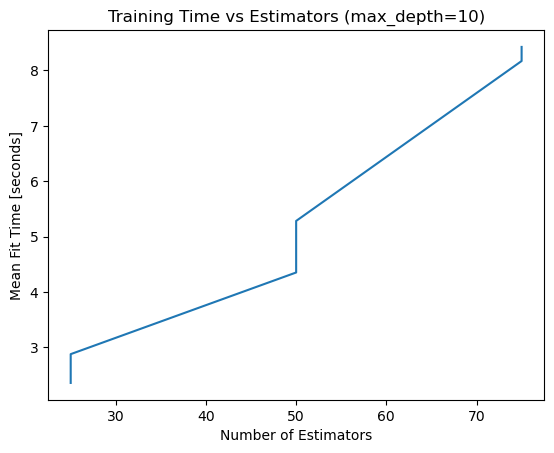

In [18]:
mask = cv_results["param_randomforestclassifier__max_depth"]==10
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

### ⏲️ Exploring the Effect of Tree Depth on Training Time

In the previous step, we observed how the **number of trees (`n_estimators`)** influences model training time.  
Now, let’s flip our perspective to explore how the **maximum tree depth (`max_depth`)** affects it.

We’ll focus on models where the number of trees is fixed at **25** to isolate the effect of tree depth.

Here’s what we’ll do:
- Create a **mask** to select rows in `cv_results` where `param_randomforestclassifier__n_estimators == 25`.  
- Plot **`param_randomforestclassifier__max_depth`** on the **x-axis** and **`mean_fit_time`** on the **y-axis**.  
- Label both axes and include a descriptive title.

This plot will show us how **increasing the tree depth** impacts **training duration**, helping us visualize the trade-off between **model complexity** and **computational cost**.


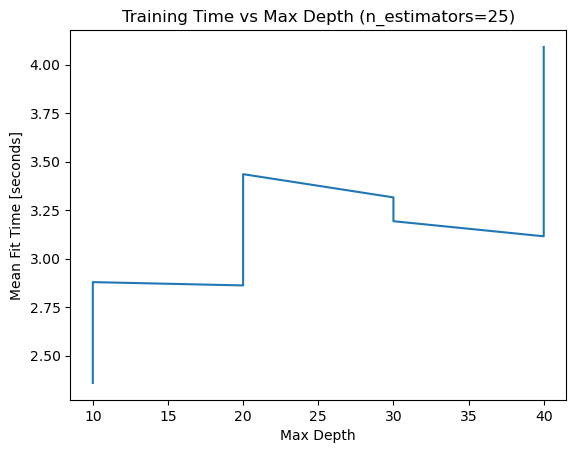

In [20]:
mask = cv_results["param_randomforestclassifier__n_estimators"]==25
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

## Evaluate

### 🧠 Evaluating Model Performance: First Impressions

Now comes the **moment of truth** — it’s time to evaluate how our tuned Random Forest model performs on unseen data.  

Good news: **we’ve beaten the baseline!** 🎉  
It might not be by a huge margin, but any improvement means our model is learning meaningful patterns from the data.

Before we dive into deeper evaluation, let’s take a look at the **class distribution** in our test set.  
By counting how many observations belong to the **positive (bankrupt)** and **negative (not bankrupt)** classes, we’ll gain a clearer understanding of what to expect in our upcoming **confusion matrix**.

This step helps ensure we interpret our results correctly, especially in the context of **imbalanced data**.


In [21]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9589


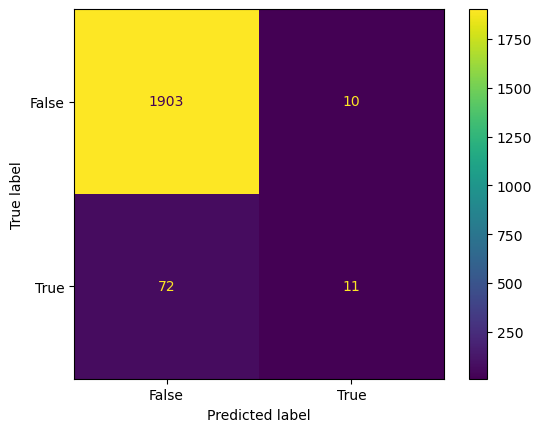

In [22]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

# Communicate

### 🌟 Feature Importance Analysis

Now that we’ve evaluated our model’s performance, let’s take a deeper look at **what features contributed most** to its predictions.

Random Forest models provide a built-in measure of **feature importance**, which indicates how much each feature contributes to reducing uncertainty (or impurity) in the model’s decisions.

We’ll:
- Extract the **top 10 most important features** from our trained model.  
- Plot them as a **horizontal bar chart** for better readability.  
- Label the x-axis as **“Gini Importance”** to show how much each feature contributes to overall model performance.  

This visualization will help us interpret the model’s behavior and understand **which factors have the strongest influence** on predicting bankruptcy.


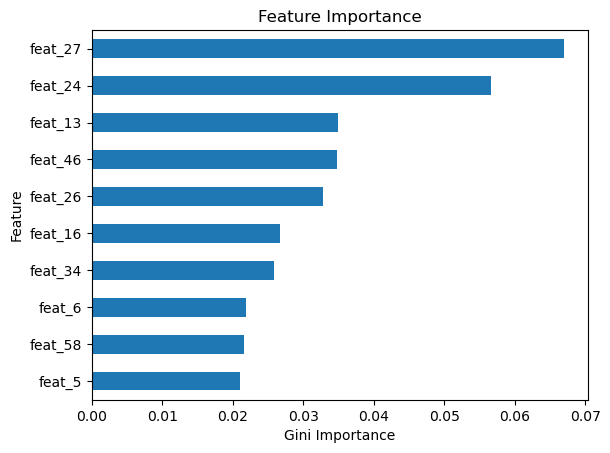

In [23]:
features = X_train_over.columns
importances = model.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

### 🤖 Making Predictions with the Saved Model

Now that we’ve successfully saved our best-performing model as **`randomForest.pkl`**, it’s time to make it useful in a real-world scenario.

To do this, we’ll create a **function** called `make_predictions()` that automates the process of generating predictions on new data.

Here’s what this function will do step-by-step:

1. **Take two arguments:**
   - The **path to a JSON file** containing the test data.  
   - The **path to the serialized model file** (in this case, `randomForest.pkl`).  

2. **Load and preprocess** the test data using the `wrangle()` function we created earlier.  
3. **Load the trained model** from disk using `pickle`.  
4. **Generate predictions** using the model’s `.predict()` method.  
5. **Convert the predictions** into a pandas `Series` named **`"bankrupt"`**, making sure it shares the same index as the test data.  
6. **Return the Series** as the final output.

This modular approach ensures that our model can easily be applied to **any new dataset** — a key step in moving from experimentation to **deployment-ready machine learning**.


In [24]:
with open("randomForest.pkl","wb") as f:
    pickle.dump(model,f)

In [26]:
def make_predictions(data_filepath, model_filepath):
    X_test = wrangle(data_filepath)
    with open(model_filepath,"rb") as f:
        model= pickle.load(f)
    y_test_pred = model.predict(X_test)
    y_test_pred = pd.Series(y_test_pred,index=X_test.index,name="bankrupt")
    return y_test_pred

In [28]:
y_test_pred = make_predictions(
    data_filepath="../data/poland-bankruptcy-data-2009-mvp-features.json.gz",
    model_filepath="randomForest.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head(5)

predictions shape: (526,)


company_id
4     False
32    False
34    False
36    False
40    False
Name: bankrupt, dtype: bool

## ✅ Conclusion

In this project, we explored how **ensemble learning** can enhance predictive performance through the use of a **Random Forest Classifier**.  
Starting from data preprocessing and resampling to hyperparameter tuning and model evaluation, we built a complete, end-to-end classification workflow.

### Key Takeaways:
- **Ensemble methods** like Random Forests reduce overfitting and improve model reliability by combining multiple decision trees.  
- **Cross-validation** and **Grid Search** helped us systematically identify the best hyperparameters.  
- We learned the trade-off between **model complexity** and **computational cost**, especially when tuning parameters like `n_estimators` and `max_depth`.  
- Finally, we **saved our best-performing model** and created a reusable **`make_predictions()`** function for future inference on unseen data.

This workflow demonstrates not only how to build an effective predictive model but also how to make it **scalable, interpretable, and production-ready** — a critical skill in real-world data science projects. 🌟
